# Overview
* 1.Create Elasticsearch index mappings and load data into Elasticsearch

* 2.Load ratings data and run ALS

* 3.Save ALS model factors to Elasticsearch

* 4.Show similar items using Elasticsearch vector scoring plugin

>### Requirements
Requires Spark 2.0.2, Elasticsearch 5.3.0, elasticsearch-hadoop 5.3.0 and elasticsearch-vector-scoring 5.3.0.
Elasticsearch vector scoring plugin must be installed first.
For reference, the code to create Elasticsearch mappings is shown here (see Enrich & Prepare MovieLens Dataset.ipynb for full details). This notebook assumes these mappings have been pre-created - so we start from Step 2.

In [1]:
from elasticsearch import Elasticsearch
es = Elasticsearch()

create_index = {
    "settings": {
        "analysis": {
            "analyzer": {
                "payload_analyzer": {
                    "type": "custom",
                    "tokenizer":"whitespace",
                    "filter":"delimited_payload_filter"
                }
            }
        }
    },
    "mappings": {
        "ratings": {
          "properties": {
                "timestamp": {
                    "type": "date"
                },
                "userId": {
                    "type": "string",
                    "index": "not_analyzed"
                },
                "movieId": {
                    "type": "string",
                    "index": "not_analyzed"
                },
                "rating": {
                    "type": "double"
                }
            }  
        },
        "users": {
            "properties": {
                "name": {
                    "type": "string"
                },
                "@model": {
                    "properties": {
                        "factor": {
                            "type": "string",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "string",
                            "index": "not_analyzed"
                        }
                    }
                }
            }
        },
        "movies": {
            "properties": {
                "genres": {
                    "type": "string"
                },
                "original_language": {
                    "type": "string",
                    "index": "not_analyzed"
                },
                "image_url": {
                    "type": "string",
                    "index": "not_analyzed"         
                },
                "release_date": {
                    "type": "date"
                },
                "popularity": {
                    "type": "double"
                },
                "@model": {
                    "properties": {
                        "factor": {
                            "type": "string",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "string",
                            "index": "not_analyzed"
                        }
                    }
                }
            }
        }
    }
}
# create index with the settings & mappings above
#es.indices.create(index="demo", body=create_index)


### Load User, Movie and Ratings DataFrames from Elasticsearch
Load data and show schemas

In [16]:
user_df = spark.read.format("es").load("demo/users")
user_df.printSchema()
user_df.select("userId", "name").show(5)

root
 |-- @model: struct (nullable = true)
 |    |-- factor: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- userId: string (nullable = true)

+------+-------------+
|userId|         name|
+------+-------------+
|     7|Gino Mccollum|
|    67|     Sue Kern|
|    77| Shirley Gray|
|    97|     Sue Kern|
|   107|Yvette Warren|
+------+-------------+
only showing top 5 rows



In [2]:

movie_df = spark.read.format("es").option("es.read.field.as.array.include", "genres").load("demo/movies")
movie_df.printSchema()
movie_df.select("movieId", "title", "genres", "release_date", "popularity").show(5)

root
 |-- @model: struct (nullable = true)
 |    |-- factor: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- image_url: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- title: string (nullable = true)

+-------+------------------+--------------------+--------------------+----------+
|movieId|             title|              genres|        release_date|popularity|
+-------+------------------+--------------------+--------------------+----------+
|   5169|    Scarlet Street|         [Film-Noir]|1945-12-28 00:00:...|  0.203637|
|   6515|You Only Live Once|  [Crime, Film-Noir]|1937-01-29 00:00:...|  0.091118|
| 

In [3]:
ratings_df = spark.read.format("es").load("demo/ratings")
ratings_df.printSchema()
ratings_df.show(5)

root
 |-- movieId: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- userId: string (nullable = true)

+-------+------+--------------------+------+
|movieId|rating|           timestamp|userId|
+-------+------+--------------------+------+
|    316|   3.0|1970-01-10 11:23:...|    50|
|    344|   2.0|1970-01-10 11:23:...|    50|
|    356|   4.0|1970-01-10 11:23:...|    50|
|    367|   4.0|1970-01-10 11:23:...|    50|
|    380|   3.0|1970-01-10 11:23:...|    50|
+-------+------+--------------------+------+
only showing top 5 rows



### 2. Run ALS

In [17]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
converted_ratings = ratings_df.select(col("userId").cast("int"), col("movieId").cast("int"), "rating")
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.1, rank=10, seed=42)
model = als.fit(converted_ratings)
model.userFactors.show(5,false)
model.itemFactors.show(5,false)

NameError: name 'false' is not defined

### 3. Write ALS user and item factors to Elasticsearch
Utility functions for converting factor vectors

In [8]:

from pyspark.sql.types import *
from pyspark.sql.functions import udf, lit

In [9]:
def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])
def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]
def vector_to_struct(x, version):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version)
vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True)]))

In [10]:
# test out the vector conversion function
test_vec = model.userFactors.select("features").first().features
print test_vec
print
print convert_vector(test_vec)

[-0.655296266078949, -0.07208383828401566, 1.184463381767273, -0.8777399063110352, 0.34049999713897705, -0.4350639879703522, 0.15437132120132446, 0.5911734104156494, 0.27180013060569763, 0.9368487000465393]

0|-0.655296266079 1|-0.072083838284 2|1.18446338177 3|-0.877739906311 4|0.340499997139 5|-0.43506398797 6|0.154371321201 7|0.591173410416 8|0.271800130606 9|0.936848700047


In [11]:
ver = model.uid
movie_vectors = model.itemFactors.select("id", vector_struct("features", lit(ver)).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version").show(5)
user_vectors = model.userFactors.select("id", vector_struct("features", lit(ver)).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version").show(5)

+---+--------------------+--------------------+
| id|              factor|             version|
+---+--------------------+--------------------+
| 10|0|-0.372702717781...|ALS_4ca8b688b0b8d...|
| 20|0|-0.523512065411...|ALS_4ca8b688b0b8d...|
| 30|0|-0.953098893166...|ALS_4ca8b688b0b8d...|
| 40|0|-0.142099410295...|ALS_4ca8b688b0b8d...|
| 50|0|-0.571230471134...|ALS_4ca8b688b0b8d...|
+---+--------------------+--------------------+
only showing top 5 rows

+---+--------------------+--------------------+
| id|              factor|             version|
+---+--------------------+--------------------+
| 10|0|-0.655296266079...|ALS_4ca8b688b0b8d...|
| 20|0|-0.085787579417...|ALS_4ca8b688b0b8d...|
| 30|0|0.14903268218 1...|ALS_4ca8b688b0b8d...|
| 40|0|-0.077729232609...|ALS_4ca8b688b0b8d...|
| 50|0|-0.223818778992...|ALS_4ca8b688b0b8d...|
+---+--------------------+--------------------+
only showing top 5 rows



In [10]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("demo/movies", mode="append")

In [11]:
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("demo/users", mode="append")

Check the data was written correctly

In [12]:
from elasticsearch import Elasticsearch
es = Elasticsearch()
es.search(index="demo", doc_type="movies", q="star wars force awakens", size=1)

{u'_shards': {u'failed': 0, u'successful': 5, u'total': 5},
 u'hits': {u'hits': [{u'_id': u'122886',
    u'_index': u'demo',
    u'_score': 15.03271,
    u'_source': {u'@model': {u'factor': u'0|0.0634189173579 1|0.660158991814 2|0.558580338955 3|-1.78641486168 4|0.739181339741 5|-0.247270599008 6|-0.972808539867 7|-0.686645627022 8|0.183911383152 9|0.499029487371',
      u'version': u'ALS_4dcbbc9d705659044346'},
     u'genres': [u'Action', u'Adventure', u'Fantasy', u'Sci-Fi', u'IMAX'],
     u'id': 122886,
     u'image_url': u'https://image.tmdb.org/t/p/w500/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg',
     u'movieId': 122886,
     u'originalTitle': u'Star Wars: Episode VII - The Force Awakens (2015)',
     u'original_language': u'en',
     u'overview': u'Thirty years after defeating the Galactic Empire, Han Solo and his allies face a new threat from the evil Kylo Ren and his army of Stormtroopers.',
     u'popularity': 13.534924,
     u'release_date': u'2015-12-15',
     u'title': u'Star Wars: Th

### 4. Recommend using Elasticsearch!

In [13]:
from IPython.display import Image, HTML, display

def fn_query(query_vec, q="*", cosine=False):
    return {
    "query": {
        "function_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script_score": {
                "script": {
                        "inline": "payload_vector_score",
                        "lang": "native",
                        "params": {
                            "field": "@model.factor",
                            "vector": query_vec,
                            "cosine" : cosine
                        }
                    }
            },
            "boost_mode": "replace"
        }
    }
}

def get_similar(the_id, q="*", num=10, index="demo", dt="movies"):
    response = es.get(index=index, doc_type=dt, id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=True)
        results = es.search(index, dt, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]

def display_similar(the_id, q="*", num=10, index="demo", dt="movies"):
    movie, recs = get_similar(the_id, q, num, index, dt)
    # display query
    q_im_url = movie['image_url']
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>Similar movies:</h2>"))
    sim_html = "<table border=0><tr>"
    i = 0
    for rec in recs:
        r_im_url = rec['_source']['image_url']
        r_score = rec['_score']
        sim_html += "<td><img src=%s width=200></img></td><td>%2.3f</td>" % (r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

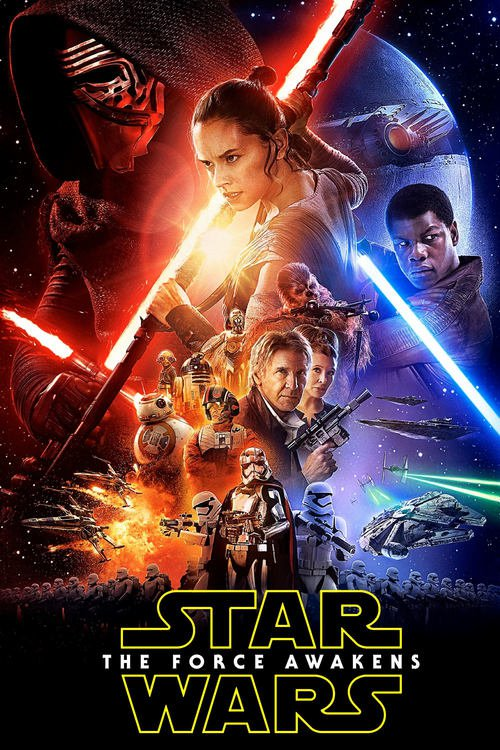

,0.937,,0.931,,0.926,,0.916,,0.914


In [14]:
display_similar(122886, num=5)

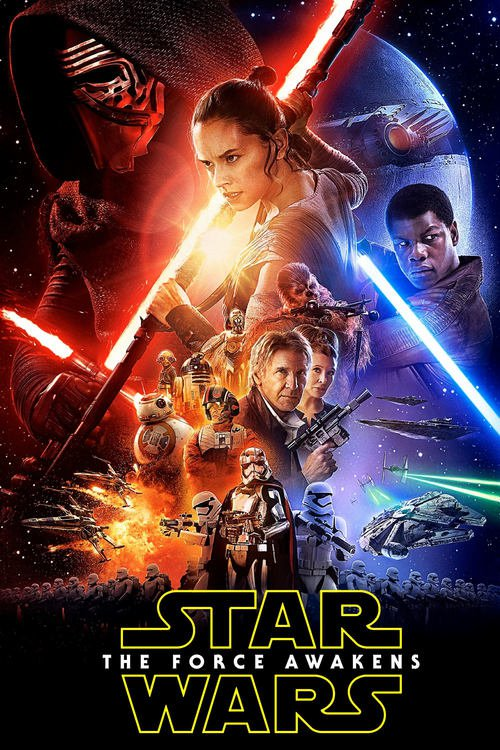

,0.926,,0.916,,0.914,,0.912,,0.911


In [18]:
display_similar(122886, num=5, q="title:(NOT trek)")

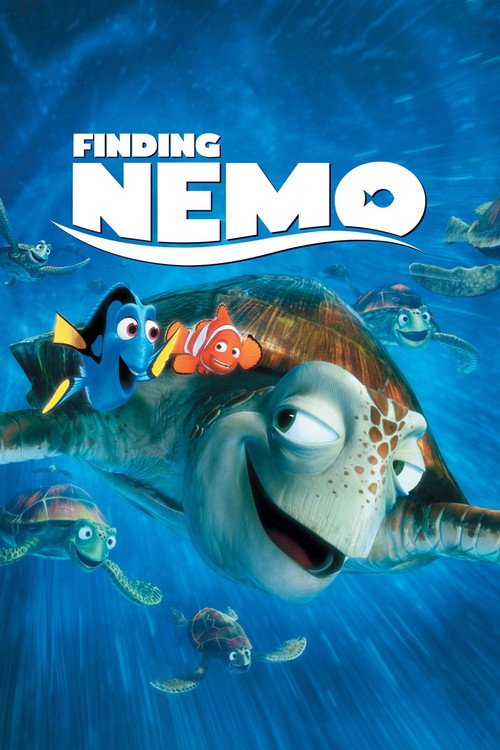

,0.920,,0.916,,0.908,,0.905,,0.900


In [15]:
display_similar(6377, num=5, q="genres:Children AND release_date:[now-5y/y TO now]")